In [9]:
from astropy.time import Time
from astropy.io import fits

blue = fits.open('../soho/blue.fits')
green = fits.open('../soho/green.fits')
red = fits.open('../soho/red.fits')

rgb = red, green, blue

rgb = [f[0].data for f in rgb]
mask = np.all([np.isfinite(f) for f in rgb], axis=0)

start = blue[0].header['DATES'][0:9]
end = blue[0].header['DATES'][14:]
start, end = Time([start, end]).jd
t = np.linspace(start, end, np.shape(rgb)[1]) - start

t = t[mask]
rgb = [f[mask].astype('float64') for f in rgb]
flux = np.sum(rgb, axis=0)/np.shape(rgb)[0]

# choose an arbitrary starting index and number of points to 
# select a segment of the (very large) SOHO timeseries 
#i = 18273
#n = 2000
#t = t[i:i+n] - np.mean(t[i:i+n])

# in parts per part 
#rgb = [f[i:i+n]/1e6 for f in rgb]

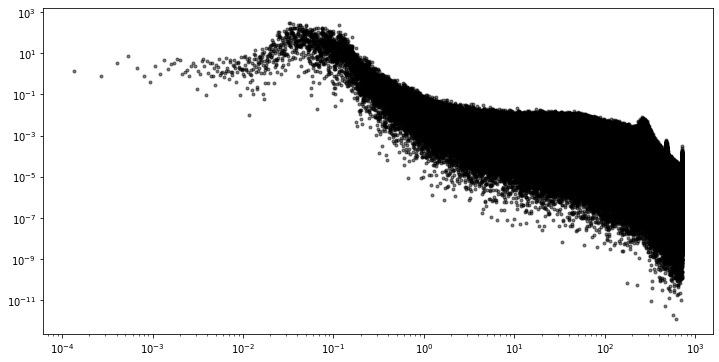

In [14]:
f = np.fft.rfftfreq(len(t), t[1] - t[0])
fft = np.fft.rfft(flux)
fft = fft*np.conj(fft)
powerfft = fft.real / len(t)**2
#ampfft = np.sqrt(powerfft / (2*np.pi)) * 1e6

pl.figure(figsize=(12, 6))
pl.loglog(f, powerfft, 'k.', alpha=0.5)

In [27]:
from scipy.signal import medfilt
filt_power = medfilt(powerfft, 501)

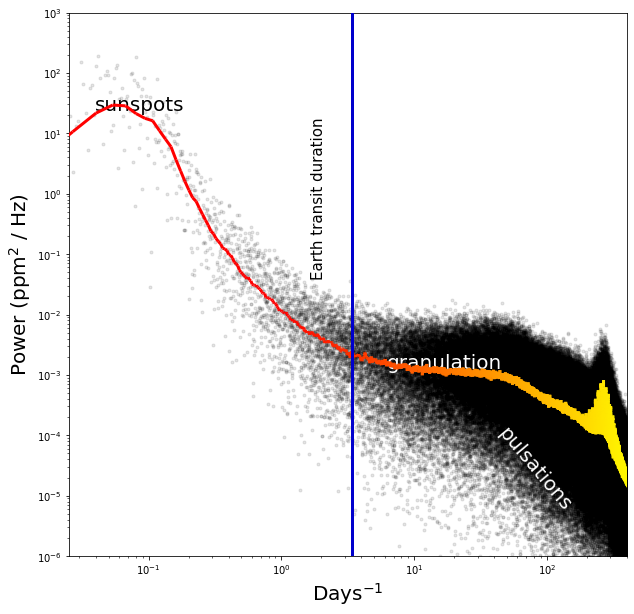

In [262]:
from matplotlib.collections import LineCollection
pl.figure(figsize=(10, 10))
pl.loglog(f[::10], powerfft[::10], 'k.', alpha=0.1, rasterized=True)

spot = f[:10000], filt_power[:10000]
gran = f[10000:1200000], filt_power[10000:1200000]
puls = f[1200000:], filt_power[1200000:]

points = np.array([f[::100], filt_power[::100]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = pl.Normalize(f.min(), f.max())
lc = LineCollection(segments, cmap='autumn', norm=mpl.colors.LogNorm(1, 500), zorder=10)
lc.set_array(f[::100])
lc.set_linewidth(3)
line = pl.gca().add_collection(lc)
pl.gca().set_yscale('log')
pl.gca().set_xscale('log')

duration_hours = 7
duration_days = duration_hours / 24
ingress_days = duration_days / 20
pl.axvline(1/duration_days, color='mediumblue', linewidth=3, alpha=1, zorder=20)

pl.annotate('sunspots', xy=(0.15, 0.82), xycoords='figure fraction', fontsize=20, rotation=0)
pl.annotate('granulation', xy=(0.61, 0.4), xycoords='figure fraction', fontsize=20, rotation=0, color='white')
pl.annotate('pulsations', xy=(0.78, 0.17), xycoords='figure fraction', fontsize=20, rotation=-50, color='white')
pl.annotate('Earth transit duration', xycoords='figure fraction', xy=(0.49, 0.55), rotation=90, fontsize=15)

pl.xlabel(r'Days$^{-1}$', fontsize=20)
pl.ylabel(r'Power (ppm$^2$ / Hz)', fontsize=20)

pl.xlim(0.025, 400)
pl.ylim(1e-6, 1e3)
pl.savefig('soho_psd.pdf')
pl.savefig('/Users/tgordon/Desktop/soho_psd.pdf', dpi=300)